# RAPIDS & Scanpy Single-Cell RNA-seq Workflow on MnPO cells

Copyright (c) 2020, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook demonstrates a single-cell RNA analysis workflow that begins with preprocessing a count matrix of size `(n_gene, n_cell)` and results in a visualization of the clustered cells for further analysis.

For demonstration purposes, we use a dataset of 1.3 M brain cells with Unified Virtual Memory to oversubscribe GPU memory.

## Import requirements

In [1]:
import numpy as np
import scanpy as sc
import anndata
import scipy.io
import scipy.sparse

import time
import os, wget


import cudf

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans
from cuml.preprocessing import StandardScaler

import cuml
import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import rmm

from rmm.allocators.cupy import rmm_cupy_allocator
import cupy
cupy.cuda.set_allocator(rmm_cupy_allocator)
from scipy import sparse
import gc
import cupy as cp
gc.collect()
cp.get_default_memory_pool().free_all_blocks()
import calculation_tool as ct

We use the RAPIDS memory manager to enable Unified Virtual Memory management, which allows us to oversubscribe the GPU memory.

## Input data

In the cell below, we provide the path to the sparse `.h5ad` file containing the count matrix to analyze. Please see the README for instructions on how to download the dataset we use here.

To run this notebook using your own dataset, please see the README for instructions to convert your own count matrix into this format. Then, replace the path in the cell below with the path to your generated `.h5ad` file.

In [ ]:

url=r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE87544&format=file&file=GSE87544%5FMerged%5F17samples%5F14437cells%5Fcount%2Etxt%2Egz"
input_file="/data/mouse_hypothalamus/GSE87544_Merged_17samples_14437cells_count.txt.gz"
input_csv="/data/mouse_hypothalamus/GSE87544_Merged_17samples_14437cells_count.txt"
if not os.path.exists(input_csv):
    print('Downloading import file...')
    os.makedirs('/data/mouse_hypothalamus', exist_ok=True)
    wget.download(url,input_file)

In [ ]:
adata=sc.read_text(input_csv)

In [ ]:
adata=adata.transpose()

In [ ]:
from scipy import sparse
sparse_X = sparse.csr_matrix(adata.X)
adata.X = sparse_X

In [ ]:
file_path="/data/mouse_hypothalamus/hypothalamus_adata.h5ad"
adata.write(file_path)

In [ ]:
adata.var_names

In [ ]:
import calculation_tool as ct
file_path="/data/mouse_hypothalamus/hypothalamus_adata.h5ad"
add_markers=["AGRP","POMC"]
adata,GPCR_df=ct.preprocess_adata_in_bulk(file_path,label=None,add_markers=add_markers)
GPCR_df.to_csv("/data/mouse_hypothalamus/hypothalamus_data_GPCR_df.csv")

In [2]:
adata=anndata.read_h5ad("/data/mouse_hypothalamus/hypothalamus_adata_processed.h5ad")
GPCR_df=pd.read_csv("/data/mouse_hypothalamus/hypothalamus_data_GPCR_df.csv",index_col=0)

In [ ]:
GPCR_df=pd.read_csv("/data/mouse_hypothalamus/hypothalamus_data_GPCR_df.csv",index_col=0)

In [ ]:
GPCR_df

In [3]:
D_R_mtx,GPCR_type_df,drug_list,GPCR_list=ct.load_parameters()
params=ct.set_parameters_for_preprocess(GPCR_list)
import calculation_tool as ct
#ct.drug_titeration(adata, GPCR_df, GPCR_type_df, drug_list, D_R_mtx)

In [ ]:
drug_conc=10**3
adata=ct.calc_drug_response(adata,GPCR_df,GPCR_type_df,drug_list,D_R_mtx,drug_conc)
selectivity_threshold=1.5
adata,num_clz_selective=ct.calc_clz_selective_cell(adata,drug_list,selectivity_threshold)

In [4]:
GPCR_adata=anndata.AnnData(X=GPCR_df)
GPCR_adata_norm=sc.pp.normalize_total(GPCR_adata,target_sum=1e4,inplace=False)['X']
GPCR_adata_norm_df=pd.DataFrame(GPCR_adata_norm,columns=GPCR_adata.var.index)

In [ ]:
GPCR_adata_norm_df

In [ ]:
sc.pl.umap(adata, color=["AGRP"])
sc.pl.umap(adata, color=["POMC"])
sc.pl.umap(adata, color=["leiden"])

In [ ]:
add_markers=["AGRP","SLC17A6","SLC32A1"] #SLC17A6=VGLUT2,SLC32A1=VGAT
for marker in add_markers:
    sc.pl.violin(adata, marker, groupby='leiden')

In [5]:
adata.obs["is_AGRP"] = adata.obs["AGRP_raw"]>0.5
print(sum(adata.obs["is_AGRP"]))
adata.obs["is_AGRP"] =adata.obs["is_AGRP"] .astype("category")

217


In [ ]:
sc.pl.umap(adata, color=["is_AGRP"])

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


# is_thirstがTrue（または1）のデータをフィルタリング
AGRP_cells = adata[adata.obs['is_AGRP'] == 1]

# 長い形式（long-form）にデータを整形
long_df = pd.melt(AGRP_cells.obs, id_vars=['is_AGRP'], value_vars=["cAMP_RISPERIDONE","cAMP_QUETIAPINE","cAMP_HALOPERIDOL",'cAMP_CLOZAPINE', 'cAMP_OLANZAPINE'])

# value=0のcellを除外
long_df=long_df[long_df.value!=0]

# ボックスプロットを作成する
plt.figure(figsize=(10, 6))
#sns.boxplot(data=long_df, x='variable', y='value',whis=(25,75),
#            showfliers=True,notch=True,medianprops={"color": "r", "linewidth": 2})
sns.violinplot(data=long_df, x='variable', y='value')
plt.title('Comparison of cAMP in AGRP cells')
plt.xlabel('Treatment')
plt.ylabel('cAMP Levels')
plt.show()

# 統計検定
clozapine_values = AGRP_cells.obs['cAMP_CLOZAPINE']
olanzapine_values = AGRP_cells.obs['cAMP_OLANZAPINE']

# t-test
t_stat, t_pval = stats.ttest_ind(clozapine_values, olanzapine_values, equal_var=False)

# Mann-Whitney U test
u_stat, u_pval = stats.mannwhitneyu(clozapine_values, olanzapine_values)

print(f"T-test statistic: {t_stat}, p-value: {t_pval}")
print(f"Mann-Whitney U test statistic: {u_stat}, p-value: {u_pval}")

In [ ]:
# 統計検定
clozapine_values = AGRP_cells.obs['cAMP_CLOZAPINE']
olanzapine_values = AGRP_cells.obs['cAMP_OLANZAPINE']
haloperidol_values = AGRP_cells.obs['cAMP_HALOPERIDOL']

# t-test
t_stat, t_pval = stats.ttest_ind(clozapine_values, haloperidol_values, equal_var=False)

# Mann-Whitney U test
u_stat, u_pval = stats.mannwhitneyu(clozapine_values, haloperidol_values)

print(f"T-test statistic: {t_stat}, p-value: {t_pval}")
print(f"Mann-Whitney U test statistic: {u_stat}, p-value: {u_pval}")

In [ ]:
import calculation_tool as ct

drug_conc=10**3
results_df_sorted,all_responses=ct.sim_inhibit_pattern_3r(adata,GPCR_adata_norm_df,GPCR_type_df,drug_conc,group_col="is_AGRP", selected_label=True,n_inhibited=3)
dir="/data/mouse_hypothalamus/AGRP"
if not os.path.exists(dir):
    os.makedirs(dir)
results_df_sorted.to_pickle(os.path.join(dir,"results_df_sorted_3r.pkl"))
all_responses.to_pickle(os.path.join(dir,"all_responses_3r.pkl"))
ct.visualize_patterns(results_df_sorted, top_n=30, top_n_for_heatmap=30, scatter_n=500)

Pattern_1: {'HTR1A_raw': True, 'HTR1B_raw': True, 'HTR1D_raw': False, 'HTR2A_raw': True, 'HTR2B_raw': True, 'HTR2C_raw': False, 'HTR3A_raw': True, 'HTR4_raw': True, 'HTR5A_raw': True, 'HTR6_raw': True, 'HTR7_raw': True, 'DRD2_raw': True, 'DRD3_raw': False, 'DRD4_raw': True, 'DRD5_raw': False, 'HRH1_raw': True, 'HRH2_raw': False, 'HRH3_raw': False, 'CHRM1_raw': True, 'CHRM2_raw': True, 'CHRM3_raw': True, 'CHRM4_raw': False, 'CHRM5_raw': False, 'ADRA1A_raw': False, 'ADRA1B_raw': True, 'ADRA2A_raw': True, 'ADRA2B_raw': False, 'ADRA2C_raw': False, 'ADRB1_raw': False, 'ADRB2_raw': False}
Pattern_2: {'HTR1A_raw': True, 'HTR1B_raw': False, 'HTR1D_raw': False, 'HTR2A_raw': False, 'HTR2B_raw': False, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': True, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD2_raw': False, 'DRD3_raw': False, 'DRD4_raw': False, 'DRD5_raw': True, 'HRH1_raw': True, 'HRH2_raw': True, 'HRH3_raw': False, 'CHRM1_raw': True, 'CHRM2_raw': False, 'CHRM3_raw': T

Simulating drug responses: 100%|██████████| 10000/10000 [02:42<00:00, 61.68it/s]


      pattern_name                                            pattern  \
6428  Pattern_6429  {'HTR1A_raw': True, 'HTR1B_raw': True, 'HTR1D_...   
2341  Pattern_2342  {'HTR1A_raw': True, 'HTR1B_raw': False, 'HTR1D...   
3334  Pattern_3335  {'HTR1A_raw': False, 'HTR1B_raw': True, 'HTR1D...   
9696  Pattern_9697  {'HTR1A_raw': False, 'HTR1B_raw': True, 'HTR1D...   
1118  Pattern_1119  {'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1...   

            diff  
6428  189.390313  
2341  185.697558  
3334  183.642626  
9696  182.038403  
1118  172.495570  


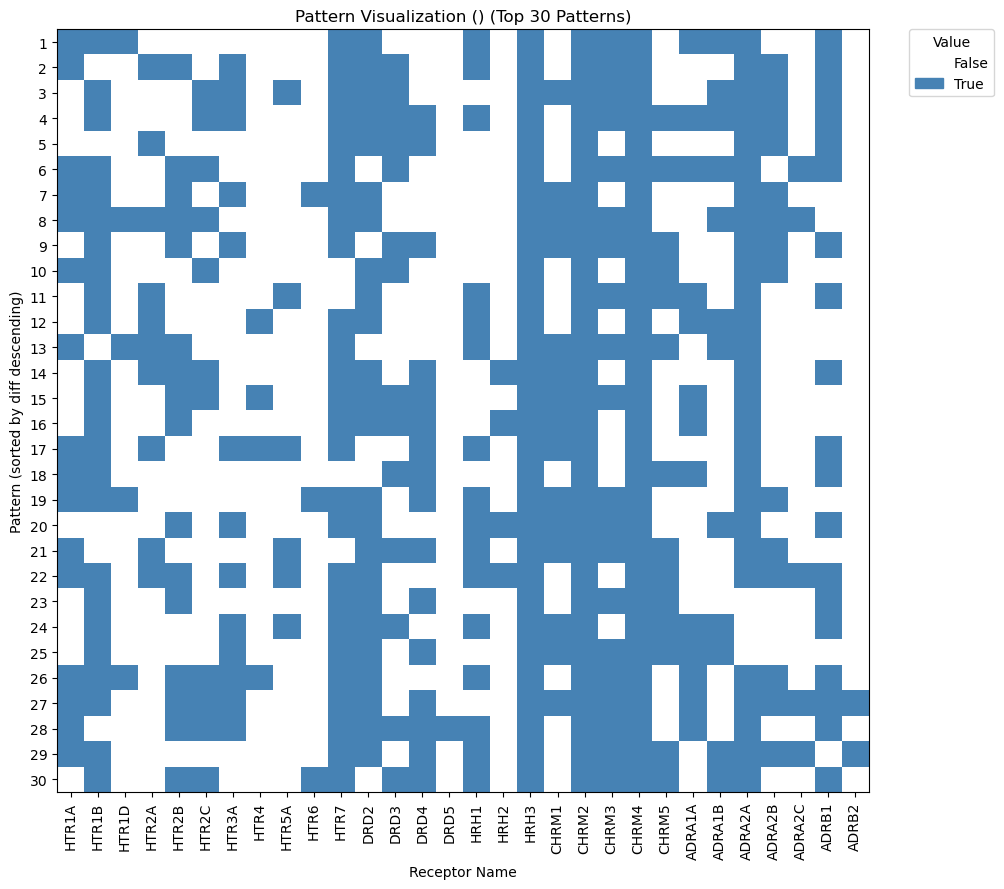

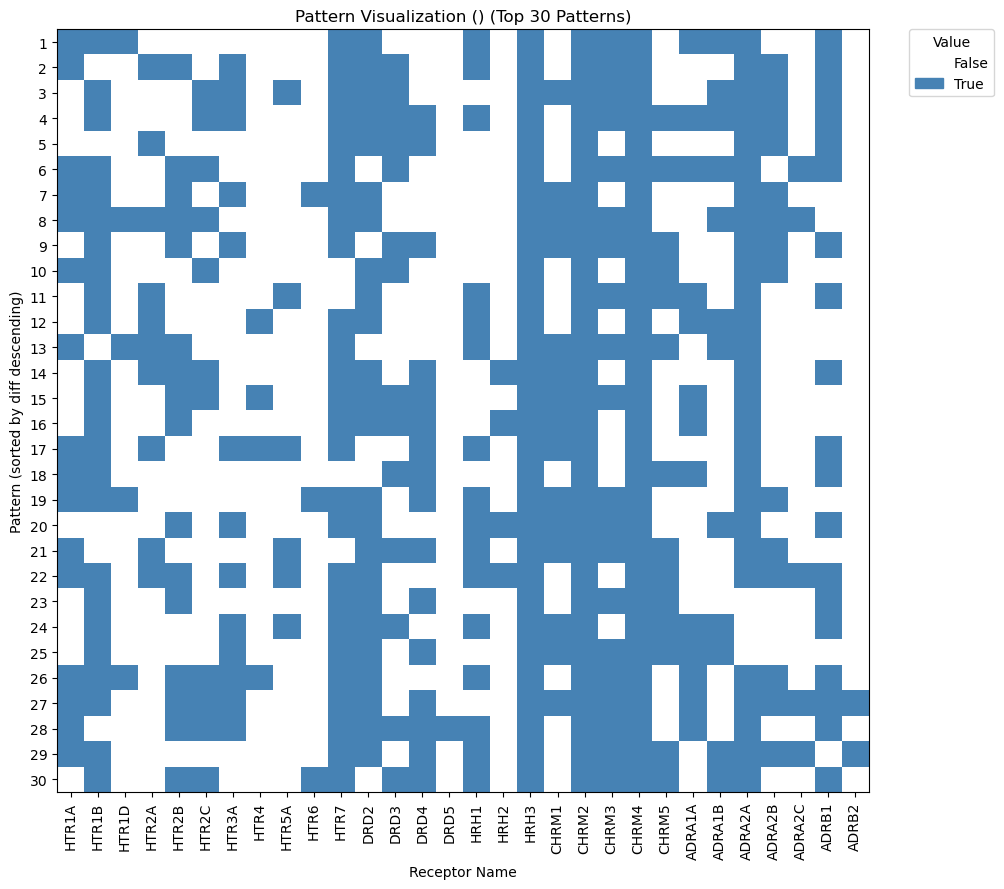

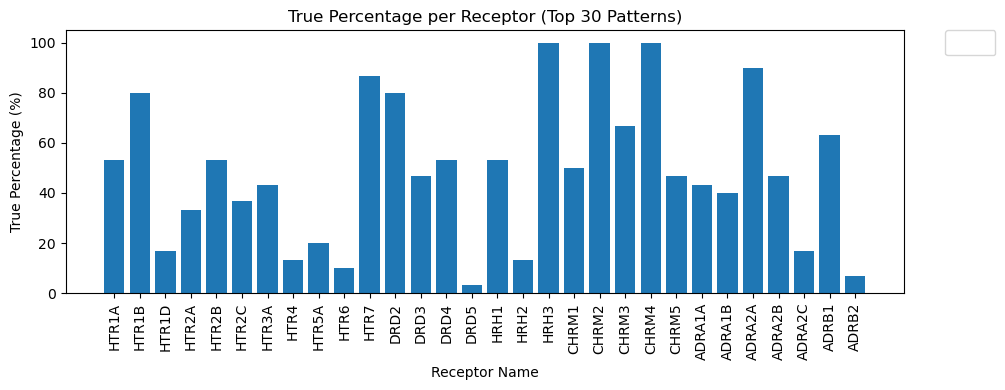

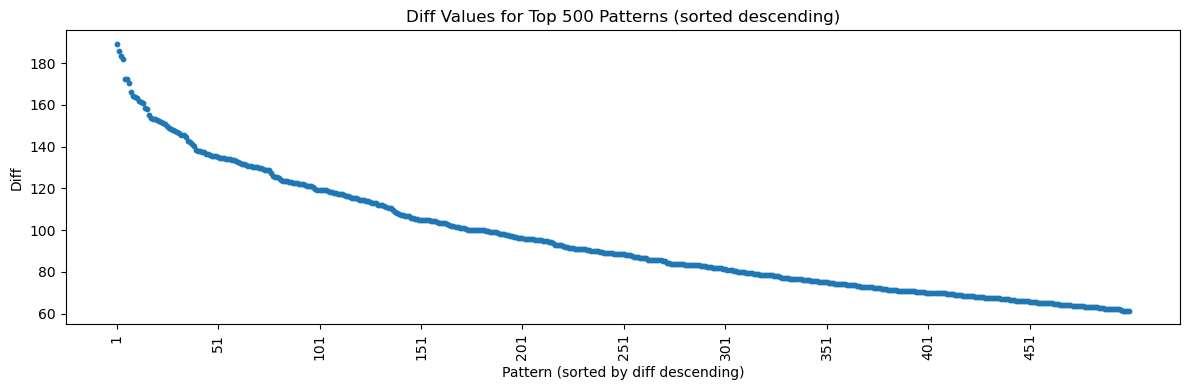

In [ ]:
import calculation_tool as ct

drug_conc=10**3
results_df_sorted,all_responses=ct.sim_inhibit_pattern_3r(adata,GPCR_adata_norm_df,GPCR_type_df,drug_conc,group_col="is_AGRP", selected_label=True,n_inhibited=0)
dir="/data/mouse_hypothalamus/AGRP-random"
if not os.path.exists(dir):
    os.makedirs(dir)
results_df_sorted.to_pickle(os.path.join(dir,"results_df_sorted_3r.pkl"))
all_responses.to_pickle(os.path.join(dir,"all_responses_3r.pkl"))
ct.visualize_patterns(results_df_sorted, top_n=30, top_n_for_heatmap=30, scatter_n=500)

Generating inhibition patterns:   0%|          | 0/27405 [00:00<?, ?it/s]

Generating inhibition patterns: 100%|██████████| 27405/27405 [00:00<00:00, 351264.24it/s]


Pattern_1: {'HTR1A_raw': True, 'HTR1B_raw': True, 'HTR1D_raw': True, 'HTR2A_raw': True, 'HTR2B_raw': False, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD2_raw': False, 'DRD3_raw': False, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False, 'CHRM1_raw': False, 'CHRM2_raw': False, 'CHRM3_raw': False, 'CHRM4_raw': False, 'CHRM5_raw': False, 'ADRA1A_raw': False, 'ADRA1B_raw': False, 'ADRA2A_raw': False, 'ADRA2B_raw': False, 'ADRA2C_raw': False, 'ADRB1_raw': False, 'ADRB2_raw': False}
Pattern_2: {'HTR1A_raw': True, 'HTR1B_raw': True, 'HTR1D_raw': True, 'HTR2A_raw': False, 'HTR2B_raw': True, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD2_raw': False, 'DRD3_raw': False, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False, 'CHRM1_raw': False, 'CHRM2_raw': False,

Simulating drug responses: 100%|██████████| 27405/27405 [06:36<00:00, 69.10it/s]


        pattern_name                                            pattern  \
26757  Pattern_26758  {'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1...   
23255  Pattern_23256  {'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1...   
24071  Pattern_24072  {'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1...   
3380    Pattern_3381  {'HTR1A_raw': True, 'HTR1B_raw': False, 'HTR1D...   
6656    Pattern_6657  {'HTR1A_raw': False, 'HTR1B_raw': True, 'HTR1D...   

             diff  
26757  135.322327  
23255  125.279081  
24071  112.466760  
3380   106.513566  
6656   104.458634  


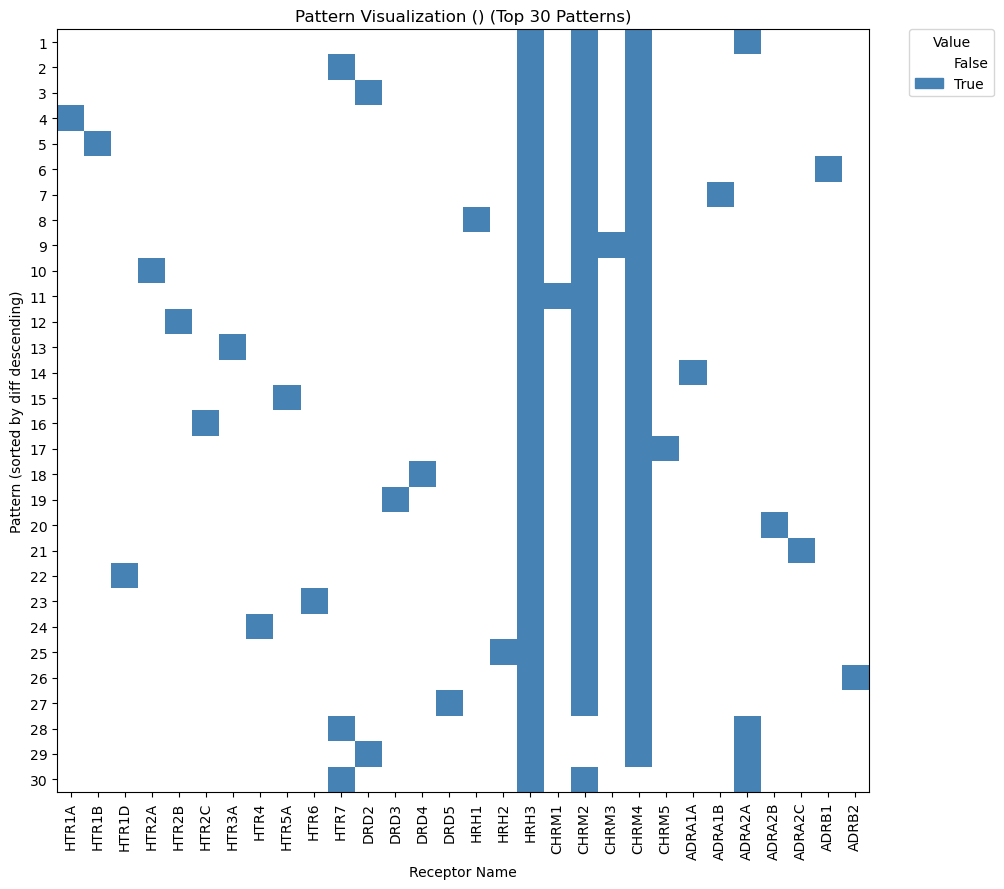

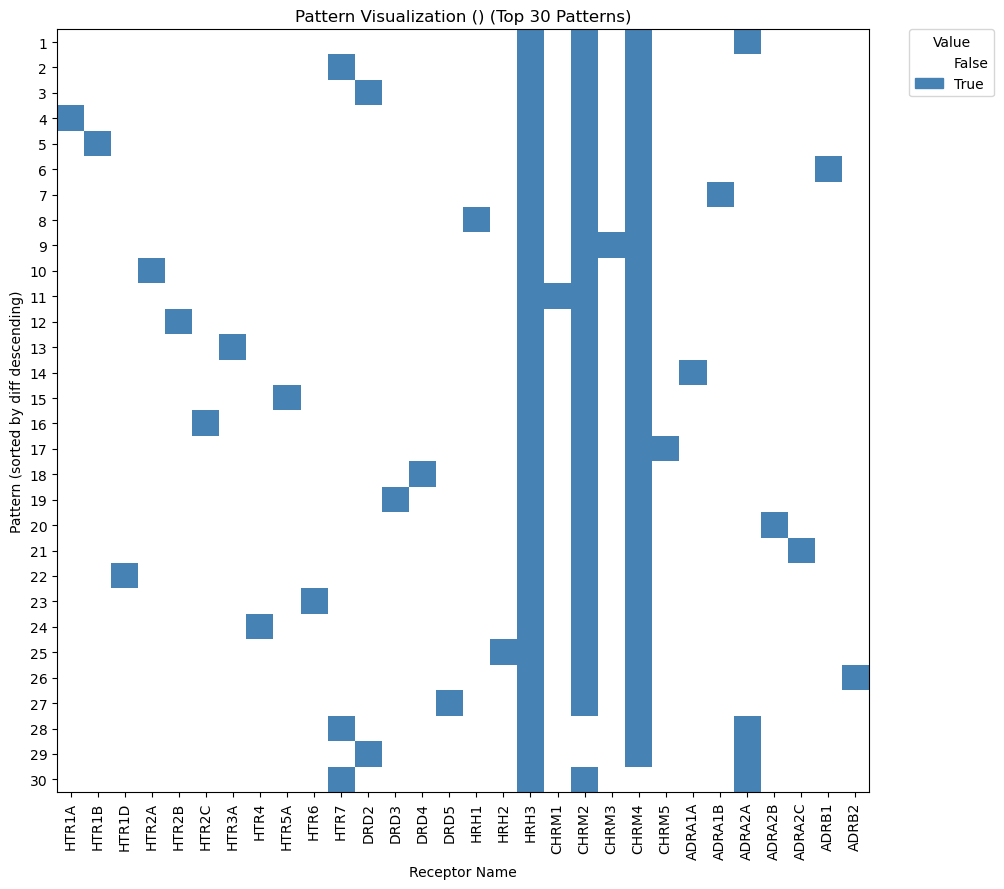

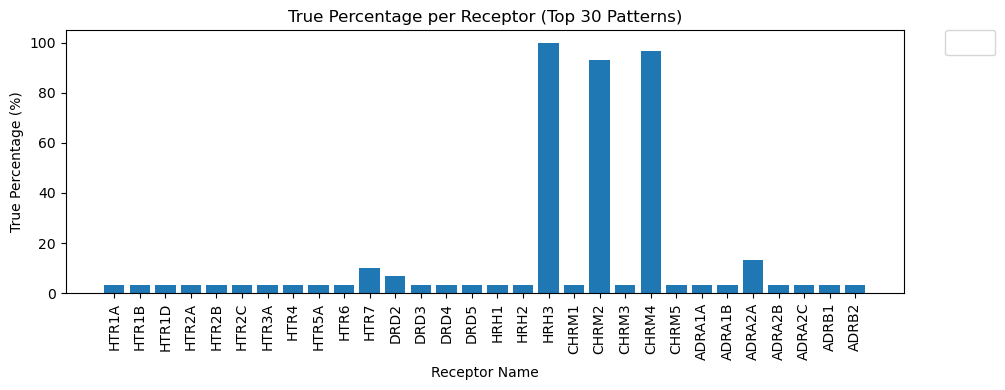

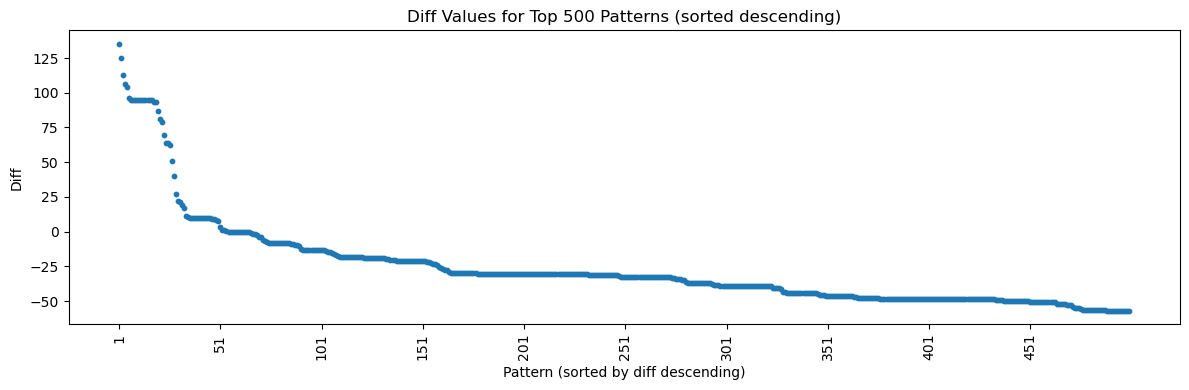

In [ ]:
import calculation_tool as ct

drug_conc=10**3
results_df_sorted,all_responses=ct.sim_inhibit_pattern_3r(adata,GPCR_adata_norm_df,GPCR_type_df,drug_conc,group_col="is_AGRP", selected_label=True,n_inhibited=4)
dir="/data/mouse_hypothalamus/AGRP-4r"
if not os.path.exists(dir):
    os.makedirs(dir)
results_df_sorted.to_pickle(os.path.join(dir,"results_df_sorted_3r.pkl"))
all_responses.to_pickle(os.path.join(dir,"all_responses_3r.pkl"))
ct.visualize_patterns(results_df_sorted, top_n=30, top_n_for_heatmap=30, scatter_n=500)

Generating inhibition patterns: 100%|██████████| 4060/4060 [00:00<00:00, 135122.99it/s]


Pattern_1: {'HTR1A_raw': True, 'HTR1B_raw': True, 'HTR1D_raw': True, 'HTR2A_raw': False, 'HTR2B_raw': False, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD2_raw': False, 'DRD3_raw': False, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False, 'CHRM1_raw': False, 'CHRM2_raw': False, 'CHRM3_raw': False, 'CHRM4_raw': False, 'CHRM5_raw': False, 'ADRA1A_raw': False, 'ADRA1B_raw': False, 'ADRA2A_raw': False, 'ADRA2B_raw': False, 'ADRA2C_raw': False, 'ADRB1_raw': False, 'ADRB2_raw': False}
Pattern_2: {'HTR1A_raw': True, 'HTR1B_raw': True, 'HTR1D_raw': False, 'HTR2A_raw': True, 'HTR2B_raw': False, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD2_raw': False, 'DRD3_raw': False, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False, 'CHRM1_raw': False, 'CHRM2_raw': Fals

Simulating drug responses:   0%|          | 0/4060 [00:00<?, ?it/s]

Simulating drug responses: 100%|██████████| 4060/4060 [00:59<00:00, 68.63it/s]


      pattern_name                                            pattern  \
3786  Pattern_3787  {'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1...   
3807  Pattern_3808  {'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1...   
3016  Pattern_3017  {'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1...   
3790  Pattern_3791  {'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1...   
3169  Pattern_3170  {'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1...   

           diff  
3786  94.915800  
3807   9.660242  
3016  -0.383004  
3790  -8.252547  
3169 -13.195324  


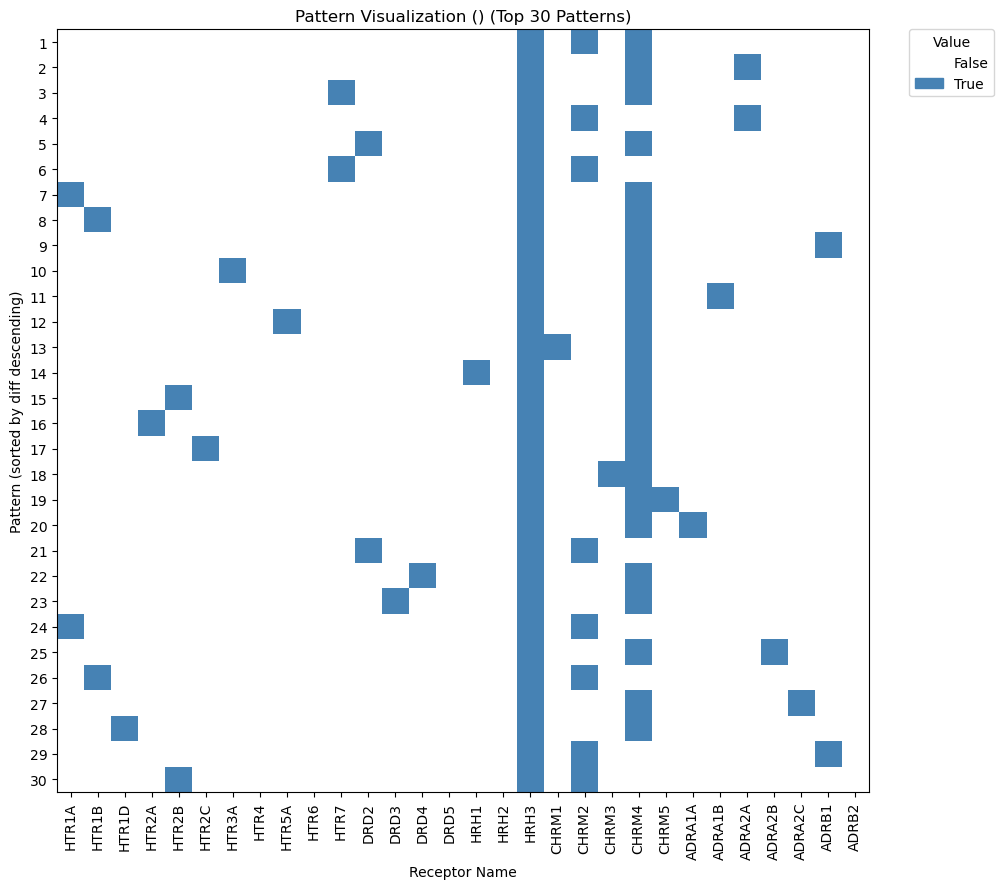

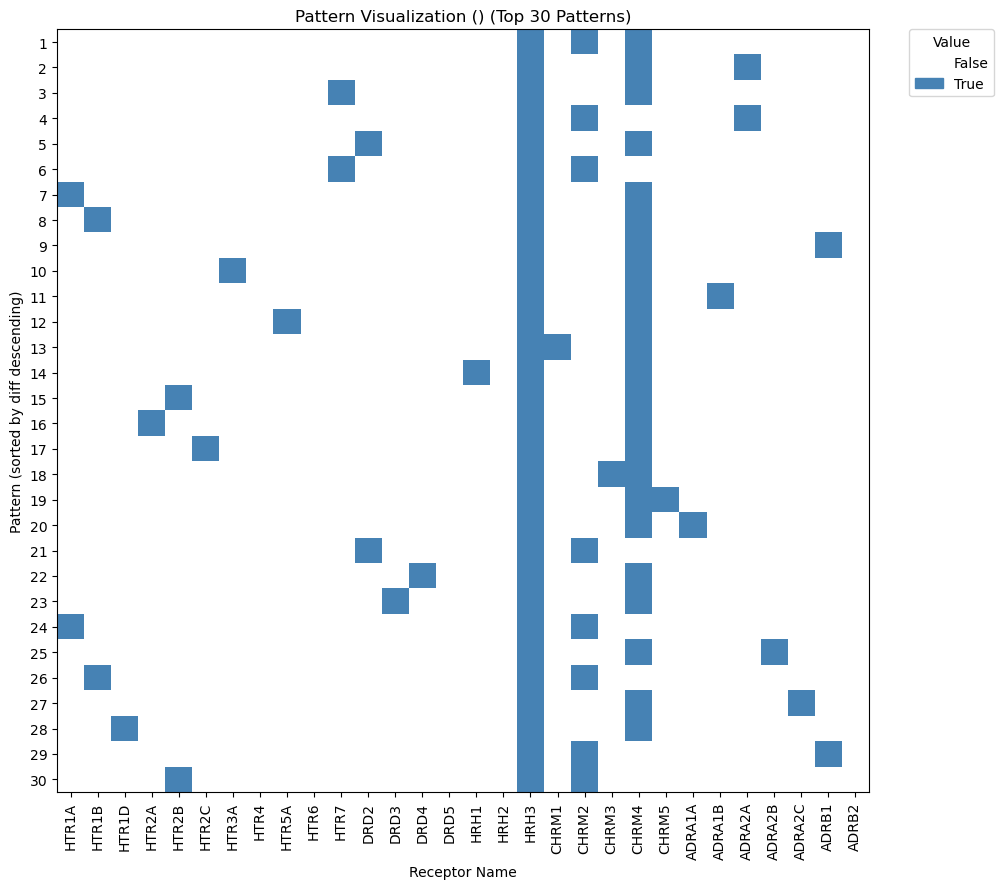

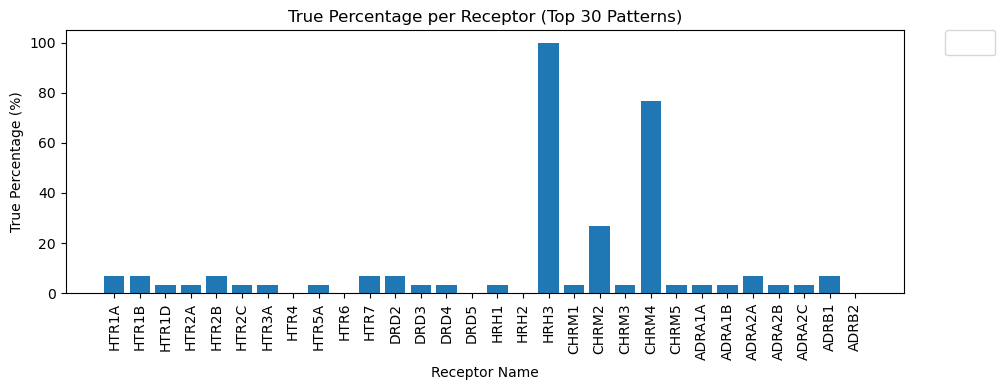

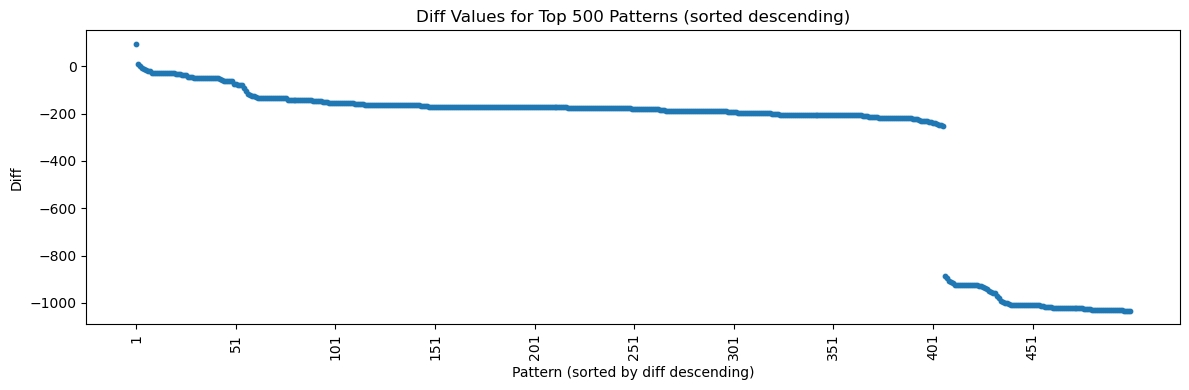

In [ ]:
import calculation_tool as ct

drug_conc=10**3
results_df_sorted,all_responses=ct.sim_inhibit_pattern_3r(adata,GPCR_adata_norm_df,GPCR_type_df,drug_conc,group_col="is_AGRP", selected_label=True,n_inhibited=3)
dir="/data/mouse_hypothalamus/AGRP-3r"
if not os.path.exists(dir):
    os.makedirs(dir)
results_df_sorted.to_pickle(os.path.join(dir,"results_df_sorted_3r.pkl"))
all_responses.to_pickle(os.path.join(dir,"all_responses_3r.pkl"))
ct.visualize_patterns(results_df_sorted, top_n=30, top_n_for_heatmap=30, scatter_n=500)

In [9]:
adata.obs["is_POMC"] = adata.obs["POMC_raw"]>1.5
print(sum(adata.obs["is_POMC"]))
adata.obs["is_POMC"] =adata.obs["is_POMC"] .astype("category")

179


Generating inhibition patterns: 100%|██████████| 4060/4060 [00:00<00:00, 182402.06it/s]


Pattern_1: {'HTR1A_raw': True, 'HTR1B_raw': True, 'HTR1D_raw': True, 'HTR2A_raw': False, 'HTR2B_raw': False, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD2_raw': False, 'DRD3_raw': False, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False, 'CHRM1_raw': False, 'CHRM2_raw': False, 'CHRM3_raw': False, 'CHRM4_raw': False, 'CHRM5_raw': False, 'ADRA1A_raw': False, 'ADRA1B_raw': False, 'ADRA2A_raw': False, 'ADRA2B_raw': False, 'ADRA2C_raw': False, 'ADRB1_raw': False, 'ADRB2_raw': False}
Pattern_2: {'HTR1A_raw': True, 'HTR1B_raw': True, 'HTR1D_raw': False, 'HTR2A_raw': True, 'HTR2B_raw': False, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD2_raw': False, 'DRD3_raw': False, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False, 'CHRM1_raw': False, 'CHRM2_raw': Fals

Simulating drug responses: 100%|██████████| 4060/4060 [00:52<00:00, 78.01it/s]


      pattern_name                                            pattern  \
3790  Pattern_3791  {'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1...   
335    Pattern_336  {'HTR1A_raw': True, 'HTR1B_raw': False, 'HTR1D...   
3309  Pattern_3310  {'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1...   
3831  Pattern_3832  {'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1...   
356    Pattern_357  {'HTR1A_raw': True, 'HTR1B_raw': False, 'HTR1D...   

           diff  
3790  84.983973  
335   13.964441  
3309 -15.044981  
3831 -28.315800  
356  -44.898073  


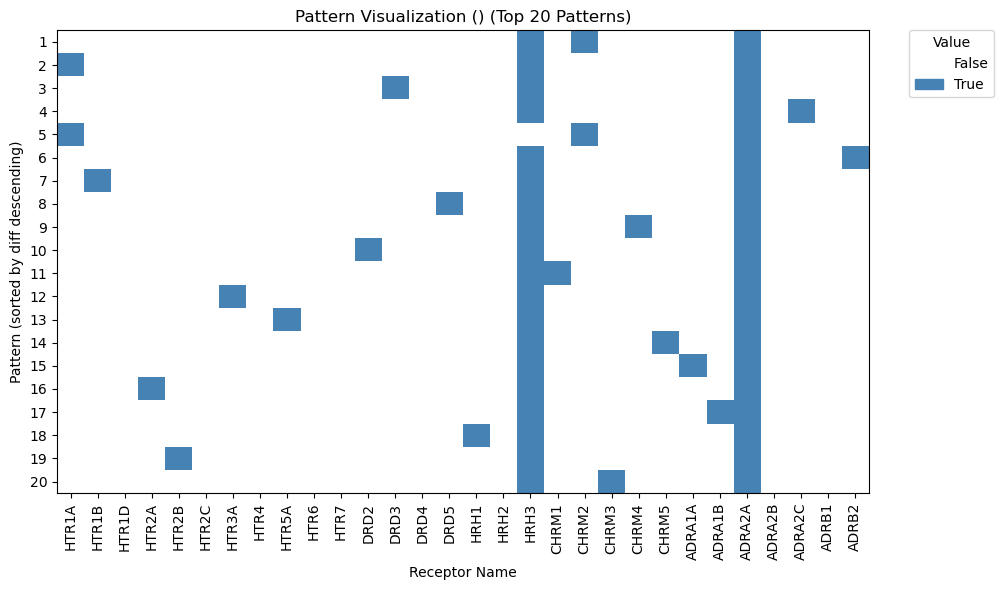

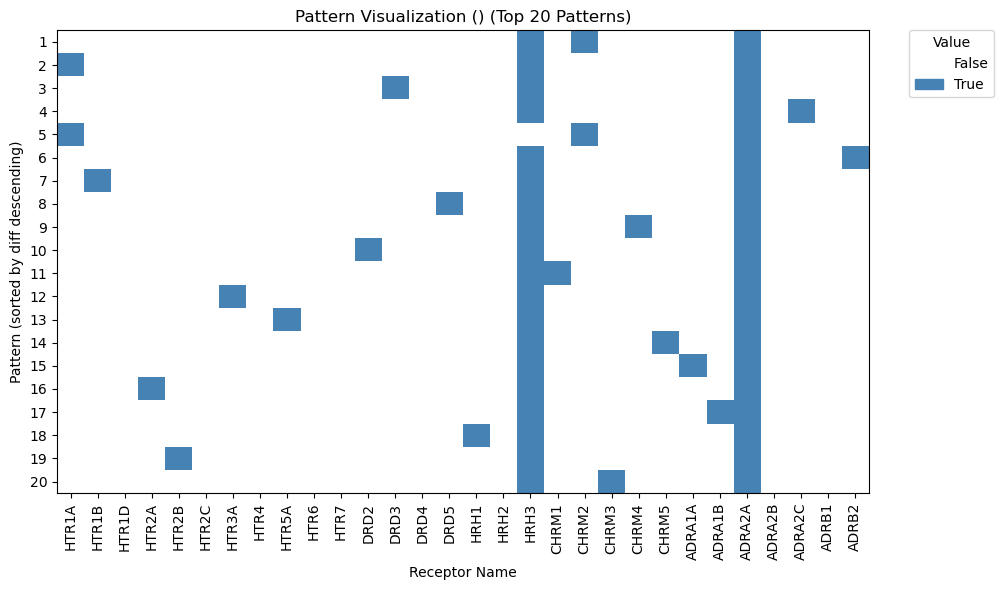

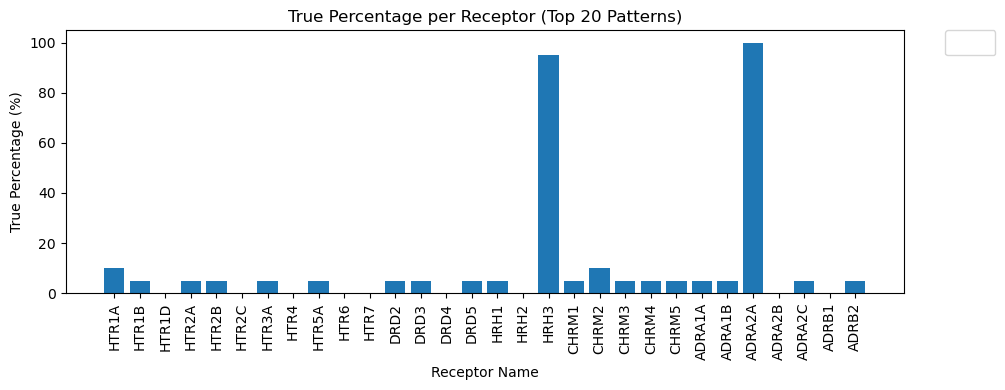

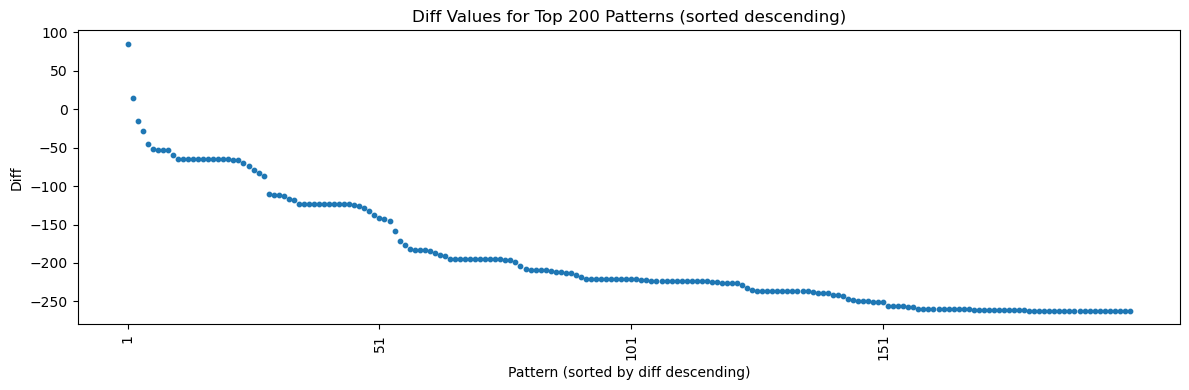

In [10]:
import calculation_tool as ct

drug_conc=10**3
results_df_sorted,all_responses=ct.sim_inhibit_pattern_3r(adata,GPCR_adata_norm_df,GPCR_type_df,drug_conc,group_col="is_POMC", selected_label=True,n_inhibited=3)
dir="/data/mouse_hypothalamus/POMC-1_5"
if not os.path.exists(dir):
    os.makedirs(dir)
results_df_sorted.to_pickle(os.path.join(dir,"results_df_sorted_3r.pkl"))
all_responses.to_pickle(os.path.join(dir,"all_responses_3r.pkl"))
ct.visualize_patterns(results_df_sorted, top_n=20, top_n_for_heatmap=20, scatter_n=200)

In [ ]:
ct.visualize_patterns(results_df_sorted, top_n=20, top_n_for_heatmap=20, scatter_n=100)